In [ ]:
# 교사모델(학습) -> GAN(생성자) -> 학생모델과 생성자 학습

In [ ]:
# 모델 경량화 : 
# 교사모델 : 가중치가 많다
# 학생모델 : 가중치가 적다

In [1]:
import torch
import torch.nn as nn
from torchvision.datasets.cifar import CIFAR10
from torchvision.transforms import Compose,ToTensor,RandomHorizontalFlip,RandomCrop,Normalize
from torch.utils.data.dataloader import DataLoader
from torchvision.models.resnet import resnet34, resnet18
from torch.optim.adam import Adam

In [2]:
tr = Compose([
    RandomCrop((32,32), padding=4),
    RandomHorizontalFlip(p=0.5),
    ToTensor(),
    Normalize(mean=(0.5,0.5,0.5),std=(0.5,0.5,0.5))
])

In [3]:
train_data = CIFAR10(root='./', train=True,download=True,transform=tr)
test_data = CIFAR10(root='./', train=False,download=True,transform=tr)

100%|██████████| 170498071/170498071 [00:04<00:00, 35839694.07it/s]


Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified


In [4]:
train_loader = DataLoader(train_data,batch_size=64,shuffle=True)
test_loader = DataLoader(test_data,batch_size=64,shuffle=False)
device = 'cuda' if torch.cuda.is_available else 'cpu'

In [5]:
# 교사모델
teacher = resnet34(pretrained=False, num_classes=10)
teacher.to(device)
lr=1e-3
op = Adam(teacher.parameters(), lr=lr)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
# 학습루프
from tqdm import tqdm
for epoch in range(30):
  iterator = tqdm(train_loader)
  for data, label in iterator:
    op.zero_grad()
    preds = teacher(data.to(device))
    loss = nn.CrossEntropyLoss()(preds,label.to(device))
    loss.backward()
    op.step()
    iterator.set_description(f"epoch:{epoch} loss:{loss.item()}")
torch.save(teacher.state_dict(), '/content/drive/MyDrive/teacher.pth')    

In [10]:
torch.save(teacher.state_dict(), '/content/drive/MyDrive/teacher.pth')    

In [11]:
from torch.serialization import MAP_LOCATION
# 교사모델 성능 평가
teacher.load_state_dict(torch.load('/content/drive/MyDrive/teacher.pth', map_location = device))
num_corr = 0
with torch.no_grad():
  for data, label in test_loader:
    output = teacher(data.to(device))
    preds = output.data.max(1)[1]
    corr = preds.eq(label.to(device).data).sum().item()
    num_corr += corr
print(f"Accuracy:{num_corr / len(test_data)}")    

Accuracy:0.8186


In [51]:
from torch.nn.modules import BatchNorm2d
# 256차원받아서  MLP층  128채널 8X8을 만들고 합성곱하고 배치 정규화를 이용해서 32X32 크기 3채널 이미지를
# GAN 생성자
import torch.nn.functional as F
class Generator(nn.Module):
  def __init__(self, dim = 256, channel = 3):
    super(Generator,self).__init__()
    # 256 -> 128 8x8
    self.l1 = nn.Sequential(nn.Linear(dim, 128*8*8))
    self.con_blocks0 = nn.Sequential(nn.BatchNorm2d(128))
    self.con_blocks1 = nn.Sequential(
        nn.Conv2d(128,128,3,stride=1,padding=1),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2)
    )
    self.con_blocks2 = nn.Sequential(
        nn.Conv2d(128,64,3,stride=1,padding=1),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.2), # 0이하의 값을 계속사용  미분이라서 한번 0이되면 더이상 가중치 없데이트 안됨
        nn.Conv2d(64,channel,3,stride=1,padding=1),
        nn.Tanh(),
        nn.BatchNorm2d(channel,affine=False) # 배치 정규화
    )
  def forward(self, z):
    # 256차원의 백터를 128채널 8x8 이미지 변환    
    out = self.l1(z.view(z.shape[0],-1))
    out = out.view(out.shape[0],-1,8,8)
    out =self.con_blocks0(out)
    # 이미지를 2배로 늘려줌
    out = nn.functional.interpolate(out,scale_factor=2)
    out = self.con_blocks1(out)
    out = nn.functional.interpolate(out,scale_factor=2)
    out = self.con_blocks2(out)
    return out

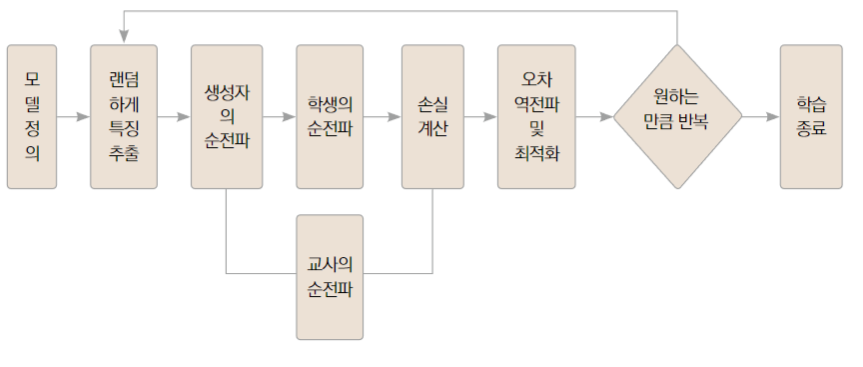

In [ ]:
from torch.optim.sgd import SGD
# 교사 모델 불러오기
teacher = resnet34(pretrained = False, num_classes = 10)
teacher.load_state_dict(torch.load('/content/drive/MyDrive/teacher.pth', map_location=device))
teacher.to(device)
teacher.eval()

In [ ]:
# 학생모델
student = resnet18(pretrained = False, num_classes = 10)
student.to(device)

In [ ]:
# 생성자 정의
generator = Generator()
generator.to(device)

In [55]:
# 생성자는 Adam으로 학생은 SGD를 이용해서 학습
G_op = Adam(generator.parameters(), lr=1e-3) # 수렴속도가 빠름
S_op = SGD(student.parameters(), lr=1e-1, weight_decay=5e-4, momentum=0.9) # 오버피팅을 피하는데 유리함

In [ ]:
# 학습
for epoch in range(500):
  # 학생모델은 5번, 생성자는 1번 가중치 학습
  for _ in range(5):
    # 이미지생성 (노이즈포함)
    noise = torch.randn(256,256,1,1,device=device)
    S_op.zero_grad()
    # 이미지 생성
    fake = generator(noise).detach()    
    # 교사 예측
    teacher_output = teacher(fake)
    # 학생 예측
    student_output = student(fake)
    # 학생오차
    s_loss = nn.L1Loss()(student_output,teacher_output.detach())
    print(f"epoch{epoch}: s_loss {s_loss}")
  #   # 역전파
    s_loss.backward()
    S_op.step()

  # 생성자 학습
  noise = torch.randn(256,256,1,1,device=device)
  G_op.zero_grad()
  fake = generator(noise)
  teacher_output = teacher(fake)
  student_output = student(fake)
  #  생성자의 오차
  g_loss = -1*nn.L1Loss()(student_output,teacher_output.detach())
  g_loss.backward()
  G_op.step()
  print(f"epoch{epoch} g_loss:{g_loss}")

In [57]:
# 모델 성능 평가
num_corr = 0
# 학습용데이터의 정확도
with torch.no_grad():
  for data,label in train_loader:
    output = student(data.to(device))
    preds = output.data.max(1)[1]
    corr = preds.eq(label.to(device).data).sum().item()
    num_corr += corr
  print(f"accuracy:{num_corr / len(train_data)}")

accuracy:0.2011


In [58]:
# 검증용 데이터
with torch.no_grad():
  for data,label in test_loader:
    output = student(data.to(device))
    preds = output.data.max(1)[1]
    corr = preds.eq(label.to(device).data).sum().item()
    num_corr += corr
  print(f"accuracy:{num_corr / len(test_data)}")

accuracy:1.2062
